# A/B тестирование

**Постановка задачи**

Наша задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
* Оценим корректность проведения теста.
* Проанализируем результаты теста.
Чтобы оценить корректность проведения теста, проверим:
* пересечение тестовой аудитории с конкурирующим тестом;
* совпадение теста и маркетинговых событий, другие проблемы временных границ теста.


**Техническое задание**

* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
  * конверсии в просмотр карточек товаров — событие product_page
  * просмотры корзины — product_cart
покупки — purchase.

Загрузим данные теста, проверим корректность его проведения и проанализируем полученные результаты.

## 1. Обзор данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

In [2]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

In [3]:
display(participants)
display(new_users)
display(events)
display(marketing_events)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


## 2. Исследование данных

### 2.1 Проверим, требуется ли преобразование типов


In [4]:
participants.info()
new_users.info()
events.info()
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 

In [5]:
# Все столбцы с датой имеют формат object
# Переведем их в datetime
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

### 2.2 Проверим пропущенные значения и дубликаты

In [6]:
# Исследуем датасеты на пропуски
display(participants.isna().sum())
display(new_users.isna().sum())
display(events.isna().sum())
display(marketing_events.isna().sum())

user_id    0
group      0
ab_test    0
dtype: int64

user_id       0
first_date    0
region        0
device        0
dtype: int64

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Как и ожидалось, пропуски есть в events['details'] — это дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах. Больше пропусков нет.

In [7]:
display(participants.duplicated().sum())
display(new_users.duplicated().sum())
display(events.duplicated().sum())
display(marketing_events.duplicated().sum())

0

0

0

0

Явных дубликатов не обнаружено.

## 3. Оценка корректности проведения теста

### 3.1 Проверим корректность всех пунктов технического задания

In [8]:
# Проверим название теста: recommender_system_test
display(participants['ab_test'].unique())

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Тест recommender_system_test имеется. Но помимо него, проводился еще один тест - interface_eu_test.

In [9]:
# Проверим Группы: А (контрольная), B (новая платёжная воронка)
display(participants['group'].unique())

array(['A', 'B'], dtype=object)

Группы A и B на месте. Единственное - эти группы пересекаются с другим тестом, но от них мы легко избавимся методом 'query'.

In [10]:
# Проверим, соответствует ли дата начала регистрации пользователей (2020-12-07) 
# и дата остановки набора новых пользователей (2020-12-21)
# Построим сводную таблицу по дате регистрации пользователей и их количеству
new_users_date = new_users.pivot_table(index='first_date', values='user_id', aggfunc='count')
new_users_date

,user_id
first_date,
2020-12-07,5595
2020-12-08,3239
2020-12-09,2101
2020-12-10,3076
2020-12-11,2390
2020-12-12,3963
2020-12-13,4691
2020-12-14,5654
2020-12-15,3043


Мы можем заметить, что после '2020-12-21' новых пользователей набирали еще два дня. Возможно, это набор пользователей для конкурирующего A/B теста

In [37]:
# Проверим соответсвует ли дата остановки теста 2021-01-04
participants_ours = participants.query('ab_test == "recommender_system_test"')
events_ours = events.merge(participants_ours, on='user_id')
events_ours['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

Тест по каким-то причинам остановили раньше, 2020-12-30.

In [38]:
# Проверим соответствует ли количество участников теста 6000
participants_ours

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Участников получилось немного больше, 6701

### 3.2 Проверим, совпадает ли время проведения теста с маркетинговыми и другими активностями

In [39]:
marketing_events.query('start_dt > "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Время нашего теста совпало с Christmas & New Year Promo в Европейских странах и Северной Америке

### 3.3 Проверка тестовой аудитории

In [14]:
# Проверим пересечение пользователей с конкурирующим тестом

# Выберем пользователей конкурирующего теста
participants_not_ours = participants.query('ab_test == "interface_eu_test"')

# Объединим пользователей нашего и конкурирубщего теста по user_id
participants_cross = participants_ours.merge(participants_not_ours, on='user_id')
participants_cross

,user_id,group_x,ab_test_x,group_y,ab_test_y
0,DABC14FDDFADD29E,A,recommender_system_test,A,interface_eu_test
1,04988C5DF189632E,A,recommender_system_test,A,interface_eu_test
2,B3A2485649E4A012,A,recommender_system_test,A,interface_eu_test
3,EAFB9027A27D510C,B,recommender_system_test,A,interface_eu_test
4,5D5E6EE92AF6E9E0,B,recommender_system_test,B,interface_eu_test
...,...,...,...,...,...
1597,C2DC7B6881CE6E30,B,recommender_system_test,B,interface_eu_test
1598,EA29547AB3C0CB9C,B,recommender_system_test,A,interface_eu_test
1599,9A44E27079666291,B,recommender_system_test,A,interface_eu_test
1600,FA86D8DFAD3ADADE,A,recommender_system_test,A,interface_eu_test


В нашем и конкурирующем тесте пересекается целых 1602 пользователя!

In [15]:
# Проверим есть ли пользователи, участвующие в двух группах теста одновременно

participants_ours_A = participants_ours.query('group=="A"')
participants_ours_B = participants_ours.query('group=="B"')

participants_ours_AB = participants_ours_A.merge(participants_ours_B, on='user_id')
participants_ours_AB

,user_id,group_x,ab_test_x,group_y,ab_test_y


У нас нет пользователей, участвующих в двух группах теста одновременно

In [16]:
# Проверим равномерность распределения пользователей по тестовым группам
display(participants_ours_A.count())
display(participants_ours_B.count())

user_id    3824
group      3824
ab_test    3824
dtype: int64

user_id    2877
group      2877
ab_test    2877
dtype: int64

* Группы распределены не совсем равномерно: 3824 против 2877.
* В нашем и конкурирующем тесте пересекается 1602 пользователя.

## 4 Исследовательский анализ данных

### 4.1 Проверим одинаково ли распределены количество событий на пользователя в выборках

In [17]:
# Создадим новые датафреймы с пользователями из нашего теста по группам A и B
events_ours_A = events.merge(participants_ours_A, on='user_id')
events_ours_B = events.merge(participants_ours_B, on='user_id')

#Cоздадим сводные таблицы с user_id и количеством событий
events_ours_A_pivot = events_ours_A.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()
events_ours_B_pivot = events_ours_B.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()

# Посмотрим как распределно количество событий на пользователя
display(events_ours_A_pivot.describe())
display(events_ours_B_pivot.describe())

,event_name
count,2747.000000
mean,7.027303
std,3.868983
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


,event_name
count,928.000000
mean,5.812500
std,3.483878
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,28.000000


Мы видим, что среднее количество событий в группах A и B различается: 7 и 5.8 соответственно. Также мы видим, что количество пользователей, которые совершали хотя бы одно событие существенно различается: 2747 и 928 соответственно. 

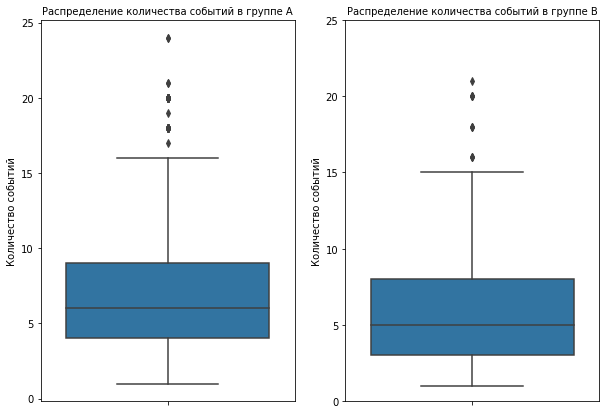

In [18]:
# Визуализируем

A = events_ours_A_pivot['event_name']
B = events_ours_B_pivot['event_name']

plt.rcParams['figure.figsize']=(10,7)
fig, axes = plt.subplots(1, 2)

ax_1 = sns.boxplot(y=A, ax=axes[0])
ax_2 = sns.boxplot(y=B, ax=axes[1])
ax_2.set_ylim(0,25)

ax_1.axes.set_title("Распределение количества событий в группе A", fontsize=10)
ax_1.set_ylabel("Количество событий", fontsize=10)

ax_2.axes.set_title("Распределение количества событий в группе B", fontsize=10)
ax_2.set_ylabel("Количество событий", fontsize=10)

plt.show()

Значимой статистической разницы среднего количества событий на пользователя нет.

### 4.2 Проверим, как число событий в выборках распределено по дням

In [75]:
# Избавимся от времени в столбце event_dt
events_ours_A['event_dt'] = pd.DatetimeIndex(events_ours_A['event_dt']).date
events_ours_B['event_dt'] = pd.DatetimeIndex(events_ours_B['event_dt']).date

# Cоздадим сводные таблицы с датой и количеством событий
events_ours_A_date = events_ours_A.pivot_table(index='event_dt', values='event_name', aggfunc='count').reset_index()
events_ours_B_date = events_ours_B.pivot_table(index='event_dt', values='event_name', aggfunc='count').reset_index()

# Создадим сводную таблицу с уникальными пользователями в каждую дату
events_ours_A_unique_users = events_ours_A.pivot_table(index='event_dt', values='user_id', aggfunc='nunique')
events_ours_B_unique_users = events_ours_B.pivot_table(index='event_dt', values='user_id', aggfunc='nunique')

# Объединим таблицу
events_ours_A_date = events_ours_A_date.merge(events_ours_A_unique_users, on='event_dt')
events_ours_B_date = events_ours_B_date.merge(events_ours_B_unique_users, on='event_dt')

# Добавим столбец с количеством действий на пользователя
events_ours_A_date['events_per_user'] = events_ours_A_date['event_name'] / events_ours_A_date['user_id']
events_ours_B_date['events_per_user'] = events_ours_B_date['event_name'] / events_ours_B_date['user_id']

# Посмотрим как распределно количество событий на пользователя по датам для групп A и B 
display(events_ours_A_date['events_per_user'].describe())
display(events_ours_B_date['events_per_user'].describe())

count    23.000000
mean      2.221459
std       0.103772
min       2.000000
25%       2.152175
50%       2.269639
75%       2.299984
max       2.349206
Name: events_per_user, dtype: float64

count    24.000000
mean      2.023096
std       0.104961
min       1.818182
25%       1.970769
50%       2.011224
75%       2.079097
max       2.242424
Name: events_per_user, dtype: float64

Мы видим, что среднее количество событий в группах A и B по дням различается незначительно: 2.2 и 2.0 соответственно.

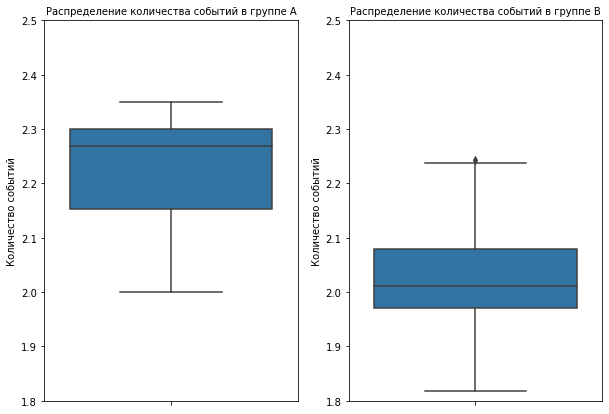

In [78]:
# Визуализируем

A = events_ours_A_date['events_per_user']
B = events_ours_B_date['events_per_user']

plt.rcParams['figure.figsize']=(10,7)
fig, axes = plt.subplots(1, 2)

ax_1 = sns.boxplot(y=A, ax=axes[0])
ax_2 = sns.boxplot(y=B, ax=axes[1])
ax_1.set_ylim(1.8,2.5)
ax_2.set_ylim(1.8,2.5)

ax_1.axes.set_title("Распределение количества событий в группе A", fontsize=10)
ax_1.set_ylabel("Количество событий", fontsize=10)

ax_2.axes.set_title("Распределение количества событий в группе B", fontsize=10)
ax_2.set_ylabel("Количество событий", fontsize=10)

plt.show()

Мы видим следующие различия в разрезе по датам в группах A и B:
* В группе A пользователь совершают 2,2 событий в день
* В группе B пользователь совершают 2,0 событий в день

### 4.3 Проверим, как меняется конверсия в воронке в выборках на разных этапах

In [21]:
# Воронка у нас следующая: login => product_page => product_cart => purchase

# Cоздадим сводные таблицы с названием события и количеством событий
events_ours_A_event_name = events_ours_A.pivot_table(
    index='event_name', values='user_id', aggfunc='count').sort_values('user_id', ascending= False).reset_index()
events_ours_B_event_name = events_ours_B.pivot_table(
    index='event_name', values='user_id', aggfunc='count').sort_values('user_id', ascending= False).reset_index()

display(events_ours_A_event_name)
display(events_ours_B_event_name)

,event_name,user_id
0,login,8566
1,product_page,5525
2,purchase,2655
3,product_cart,2558


,event_name,user_id
0,login,2624
1,product_page,1405
2,product_cart,689
3,purchase,676


In [93]:
# Построим воронку для группы A
fig = go.Figure(
    go.Funnel(
        y=[
            'Авторизация',
            'Просмотры карточек товаров ',
            'Просмотры корзины',
            'Оплата',
        ],
        x=[8566, 5525, 2558, 2655],
    )
)
fig.show() 

In [95]:
# Построим воронку для группы B
fig = go.Figure(
    go.Funnel(
        y=[
            'Авторизация',
            'Просмотры карточек товаров ',
            'Просмотры корзины',
            'Оплата',
        ],
        x=[2624, 1405, 689, 676],
))
fig.show() 

**Конверсия групп A и B следующая:**

Событие | Конверсия в группе A относительно предыдущего шага | Конверсия в группе B относительно предыдущего шага | Конверсия в группе А относительно регистрации | Конверсия в группе B относительно регистрации 
---|---|--- | --- |---
Просмотры карточек товаров | 64.5% | 53.5% |  64.5% | 53.5% | 
Просмотры корзины | 46.3% | 49% |  29.9% | 26.3% | 
Оплата | 103.8% | 98.1% |  31% | 25.8% | 

Конверсия относительно первого шага лучше в группе A. Конверсия в группе A относительно предыдущего шага в оплате товара составила 103.8%. Скорее всего это связано с тем, что пользователи оплатили несколько товаров в корзине.

### 4.4 Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

**В результате исследовательского анализа данных выявлены следующие особенности:**
1. Среднее количество событий в группах A и B на одного пользователя различается: 7 и 5.8 соответственно.
2. Количество пользователей, которые совершали хотя бы одно событие в группах A и B существенно различается: 2747 и 928 соответственно.
2. Среднее количество событий в группах A и B по дням различается: 839 и 225 соответственно.
3. Различия в разрезе по датам в группах A и B существенны:
* В группе A пользователи совершают от 379,5 до 1168 событий в день
* В группе B пользователи совершают от 146,7 до 298 событий в день
4. Конверсия в группе A относительно предыдущего шага в оплате товара составила 103.8%.

## 5 Оценка результатов A/B-тестирования

### 5.1 Что можно сказать про результаты A/B-тестирования

По результатам A/B-тестирования пользователи с новой платежной воронкой показали ухудшение конверсии на каждом шаге относительно момента регистрации.

Событие | Конверсия в группе А | Конверсия в группе B
---|---|--- 
Просмотры карточек товаров |   64.5% | 53.5% | 
Просмотры корзины |  29.9% | 26.3% | 
Оплата |  31% | 25.8% | 

### 5.2 Проверка статистической разницы долей z-критерием

In [24]:
# Здесь мы будем иметь дело со следующими датасетами:
display(events_ours_A_event_name)
display(events_ours_B_event_name)

,event_name,user_id
0,login,8566
1,product_page,5525
2,purchase,2655
3,product_cart,2558


,event_name,user_id
0,login,2624
1,product_page,1405
2,product_cart,689
3,purchase,676


Для каждой проверки будет две гипотезы:
* H0 - нет оснований считать доли разными
* H1 - между долями есть значимая разница

In [25]:
# Напишем функцию для проверки статистической разницы долей z-критерием

def return_hypothesis_test (success, trials):
    alpha = .05
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [26]:
# Проведем проверку
print('конверсии в просмотр карточек товаров — product_page')
return_hypothesis_test(np.array([events_ours_A_event_name['user_id'][1], events_ours_B_event_name['user_id'][1]]), 
                       [events_ours_A_event_name['user_id'][0], events_ours_B_event_name['user_id'][0]])
print('конверсии в просмотры корзины — product_cart')
return_hypothesis_test(np.array([events_ours_A_event_name['user_id'][2], events_ours_B_event_name['user_id'][2]]), 
                       [events_ours_A_event_name['user_id'][0], events_ours_B_event_name['user_id'][0]])
print('конверсии в покупки — purchase')
return_hypothesis_test(np.array([events_ours_A_event_name['user_id'][3], events_ours_B_event_name['user_id'][3]]), 
                       [events_ours_A_event_name['user_id'][0], events_ours_B_event_name['user_id'][0]])

конверсии в просмотр карточек товаров — product_page
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

конверсии в просмотры корзины — product_cart
p-значение:  3.517589978851987e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

конверсии в покупки — purchase
p-значение:  5.0401285166312704e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница



**Во всех трех долях (конверсия в просмотр карточек товаров, конверсия в просмотры корзины, конверсия в покупки ) есть статистически значимая разница.**

## 6 Общий вывод

### Выводы по оценке результатов A/B-теста

1. Мы нашли пропуски в events['details'] в разделе покупок, purchase, в этом поле хранится стоимость покупки в долларах. Больше пропусков нет. Дубликатов не обнаружено.
2. Тест по каким-то причинам остановили раньше, 2020-12-30.
3. Время нашего теста совпало с Christmas & New Year Promo в Европейских странах и Северной Америке.
4. В нашем и конкурирующем тесте пересекается 1602 пользователя.
5. Нет пользователей, участвующие в двух группах теста одновременно.
6. Группы распределены не совсем равномерно: 3824 против 2877
7. Среднее количество событий в группах A и B на одного пользователя различается: 7 и 5.8 соответственно.
8. Количество пользователей, которые совершали хотя бы одно событие в группах A и B существенно различается: 2747 и 928 соответственно.
9. Среднее количество событий в группах A и B по дням различается: 839 и 225 соответственно.
10. Различия в разрезе по датам в группах A и B существенны:
* В группе A пользователи совершают от 379,5 до 1168 событий в день
* В группе B пользователи совершают от 146,7 до 298 событий в день

11. Конверсия групп A и B следующая:

Событие | Конверсия в группе A относительно предыдущего шага | Конверсия в группе B относительно предыдущего шага | Конверсия в группе А относительно регистрации | Конверсия в группе B относительно регистрации 
---|---|--- | --- |---
Просмотры карточек товаров | 64.5% | 53.5% |  64.5% | 53.5% | 
Просмотры корзины | 46.3% | 49% |  29.9% | 26.3% | 
Оплата | 103.8% | 98.1% |  31% | 25.8% | 

12. Конверсия относительно первого шага лучше в группе A. Конверсия в группе A относительно предыдущего шага в оплате товара составила 103.8%. Скорее всего это связано с тем, что пользователи оплатили несколько товаров в корзине.

13. Во всех трех долях (конверсия в просмотр карточек товаров, конверсия в просмотры корзины, конверсия в покупки ) есть статистически значимая разница.

###  Общее заключение

Тест, в целом, проведен не корректно:
* Группы не одинаковые (3824 против 2877 пользователей)
* Время нашего теста совпало с маркетинговым событием Christmas & New Year Promo в Европейских странах и Северной Америке
* Тест по каким-то причинам остановили раньше, 2020-12-30
* Обнаружено пересечение 1602 пользователей в нашем и конкурирующем тесте

**В результате теста было обнаружено, что новая платежная воронка ухудшает конверсию на каждом шаге**